In [1]:
import os
import sys
import pandas as pd
import numpy as np
import json as json
import glob
import matplotlib.pyplot as plt 

from config import DATASETS, DEFAULT, MARGIN

In [2]:
from algorithms.klcpd_ import klcpd 
from algorithms.bocpdms_ import bocpdms
from algorithms.binseg import binseg #comment this line if R is not installed 
from algorithms.mssa import mssa
from algorithms.mssa_mw import mssa_mw
from algorithms.no_change import no_change
from algorithms.microsoft_ssa import microsoft_ssa 

from algorithms.utils import format_params
from evaluation.classification import f1_score


In [3]:
ALGORITHMS = {
    "microsoft_ssa":microsoft_ssa, #comment this line if R is not installed 
    "klcpd": klcpd,
    "bocpdms": bocpdms,
    "binseg": binseg, 
    "mssa": mssa,
    "mssa_mw": mssa_mw, 
    "no_change": no_change
}

In [4]:
data_path = os.path.join(os.getcwd(), 'data')
best_params_path = os.path.join(os.getcwd(), 'best_params')

# Prepare Experiment 

## Specify algorithm, parameters, and data

In [29]:
# Choose one of the following benchamrked algorithms: binseg, microsoft_ssa, klcpd, bocpdms, mssa, mssa_mw
algorithm = "mssa"
# Choose one of the following datasets: 
    ## Synthetic: "energy", "mean", "mixed", "frequency"
    ## Benchmark: "beedance", "hasc", "occupancy", "yahoo"
dataset = "occupancy"
# Choose eaither: 
    ## A specific time series from the dataset to report F1-score for (e.g. "mean1", see config.py for naming)
    ## or choose "all" to run CPD on all time series in the dataset and report the average F1-score
time_series = "occupancy"
# Choose either: 
    ## "default" to run the detection with the default set of parameters
    ## "best" to run the detection with the best set of parameters for each time_series
    ## "custom" to specify a custom parameter configuration (if this is chosen, define the params in the next cell)
params_type = "best"


# Perform detection 

F1-score = 0.5263157894736842


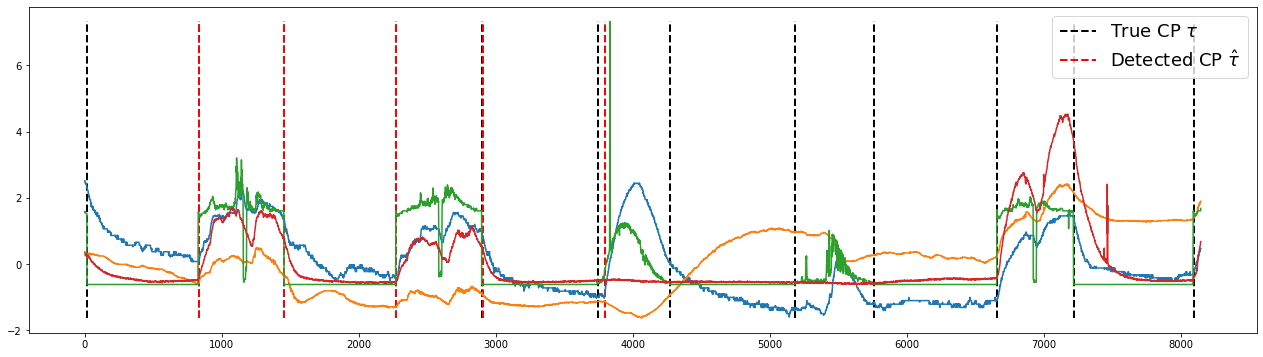

In [31]:

params = dict()

with open(os.path.join(data_path, dataset,"meta.json")) as f:
    meta_data = json.load(f)

if params_type == "default":
    params = DEFAULT[algorithm].copy()
    params = format_params(algorithm, params, meta_data)

if time_series == "all": 
    scores_list = []
    for time_series_name in DATASETS[dataset]: 
        # Load best params if specified
        if params_type == "best":
            file = glob.glob(os.path.join(best_params_path, algorithm, dataset, "{}_*.json".format(time_series_name)))[0]
            with open(file) as f:
                params = json.load(f)
                params = params["param"]
                params = format_params(algorithm, params, meta_data)

        # Load time series data
        ts = pd.read_csv(os.path.join(data_path,  dataset,"{}_ts.csv".format(time_series_name)), header=None)
        ts = ts.values[:, 1:]
        if algorithm == "binseg" or algorithm == "microsoft_ssa": 
            ts = np.linalg.norm(ts, ord = 2, axis = 1)
        model = ALGORITHMS[algorithm](**params)
        model.train(ts)
        model.detect(ts)
        labels = pd.read_csv(os.path.join(data_path, dataset,"{}_labels.csv".format(time_series_name)), header=None).iloc[:,:]
        score = f1_score(labels, model.cp, MARGIN)
        scores_list.append(score)
    print("Average F1-score across time series = {}".format(np.mean(scores_list)))
    print("Standard deviation F1-score across time series = {}".format(np.std(scores_list)))

else: 
    if params_type == "best":
        # Load best params if specified
        file = glob.glob(os.path.join(best_params_path, algorithm, dataset, "{}_*.json".format(time_series)))[0]
        with open(file) as f:
            params = json.load(f)
            params = params["param"]
            params = format_params(algorithm, params, meta_data)
        
    # Load time series data
    ts = pd.read_csv(os.path.join(data_path,  dataset,"{}_ts.csv".format(time_series)), header=None)
    ts = ts.values[:, 1:]
    if algorithm == "binseg" or algorithm == "microsoft_ssa": 
        ts = np.linalg.norm(ts, ord = 2, axis = 1)
    model = ALGORITHMS[algorithm](**params)
    model.train(ts)
    model.detect(ts)
    labels = pd.read_csv(os.path.join(data_path, dataset,"{}_labels.csv".format(time_series)), header=None).iloc[:,:]
    score = f1_score(labels, model.cp, MARGIN)
    print("F1-score = {}".format(score))
    fig = plt.figure(figsize = [22, 6])
    plt.plot(model.ts)
    plt.vlines(labels.values[1:, 0], np.min(model.ts), np.max(model.ts), linestyle = "--", color="black", linewidth = 2, label=r"True CP $\tau$")
    plt.vlines(np.array(model.cp)[1:, 0], np.min(model.ts), np.max(model.ts), linestyle = "--", color="red", linewidth = 2, label=r"Detected CP $\hat{\tau}$")
    plt.legend(fontsize=18, loc="upper right")
        